In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20987, 28)
(20987, 3)


In [6]:
X_motion_CoM[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 0.23051781299999163, 0.1655742714433,
       -0.40774758989619997, 0.2341179489999945, -0.1641604241797,
       -0.4077428318662, -0.2458713250000102, 0.1643310085713,
       -0.4077813050943, -0.24857248099999651, -0.1633396735827,
       -0.40777665639239996, False, True, True, False, 0.10000000149, 0.0,
       0.0], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(10648,)

## Predict CoM -> x

In [10]:
X_motion_CoM_FL_RR[:10, 9:11]

array([[0.2224266859999915, 0.1710351633426],
       [0.2281971279999908, 0.1739564089398],
       [0.21789033199999608, 0.17867879319590002],
       [0.22413275600000304, 0.1788051195195],
       [0.22693095500000027, 0.1785953969031],
       [0.22885501999999747, 0.1768673318303],
       [0.22970366600000602, 0.17621037756309998],
       [0.23145718499999646, 0.1775626446602],
       [0.22866560199999242, 0.1780413683529],
       [0.23152613199999905, 0.1761139880524]], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.0069339709574762765, 0.003976454186229522, 7.877599662749484e-05],
      dtype=object)

### Linear Regression

In [57]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position


# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9693478351751008
RMSE:  0.00766424199213853
The lowest error is:  6.363078504283484e-07
The highest error is:  0.1367574843824953
The avg. error is:  0.003825538148404952


In [58]:
model_fl_com_x.coef_

array([[ 1.95381409e-03, -1.59354717e-02, -2.51731596e-02,
         1.20968452e-01,  3.53030037e-02, -6.28179889e-05,
         3.21341453e-02,  2.95578674e-02,  4.76921099e-02,
        -1.87995344e-03, -3.59223846e-03,  6.36765154e-02,
         2.15180751e-01, -2.06471610e-03,  8.61543005e-02,
        -8.13064732e-02,  7.57800803e-02, -9.67839525e-02,
         1.91382153e-01,  3.40313460e-03]])

In [59]:
model_fl_com_x.intercept_

array([-0.00462337])

In [60]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 14)

Text(0, 0.5, 'Predictions')

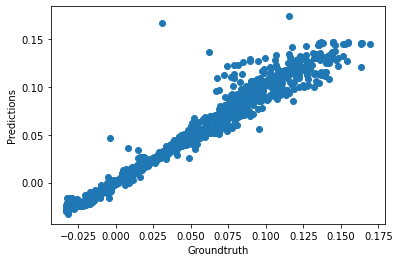

In [61]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [62]:
#%store model_fl_com_x

In [63]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [64]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [65]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9611781014692741
RMSE:  0.008096080247935313
The lowest error is:  3.846471524314443e-07
The highest error is:  0.2038259154351082
The avg. error is:  0.0037387797622841657


In [66]:
model_fl_com_y.coef_

array([[-2.57526733e-02,  1.15113842e-02, -3.01514800e-02,
         3.32356307e-02,  1.52764565e-01, -1.56411481e-04,
         3.89400513e-02,  1.59985544e-02, -1.22343026e-02,
        -2.17108622e-03, -6.09363857e-02,  7.48597376e-02,
         7.78185885e-02,  2.27045865e-01, -4.15819576e-02,
         1.78980234e-02, -3.82764959e-02,  3.82597761e-03,
         7.10120050e-02,  2.23208244e-01]])

In [67]:
model_fl_com_y.intercept_

array([0.00103609])

Text(0, 0.5, 'Predictions')

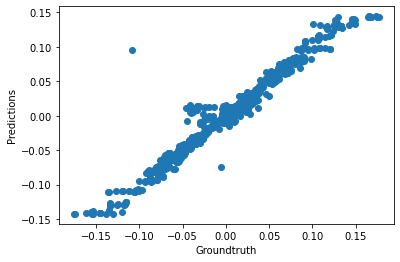

In [68]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [69]:
#%store model_fl_com_y

In [70]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [71]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [72]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9691091533591609
RMSE:  0.006063340932668478
The lowest error is:  1.1370626716961877e-06
The highest error is:  0.13378686176136478
The avg. error is:  0.0018675629024685083


In [73]:
model_fl_com_theta.coef_

array([[ 0.00343642,  0.0027297 ,  0.07613084, -0.00175182, -0.00254914,
         0.02825271, -0.00225602, -0.00306501, -0.00593673,  0.00566103,
         0.05009655,  0.07933354,  0.03741864, -0.00270922,  0.02961297,
         0.00568369,  0.0221484 , -0.0010134 ,  0.03138302,  0.00456071]])

In [74]:
model_fl_com_theta.intercept_

array([-0.00081345])

Text(0, 0.5, 'Predictions')

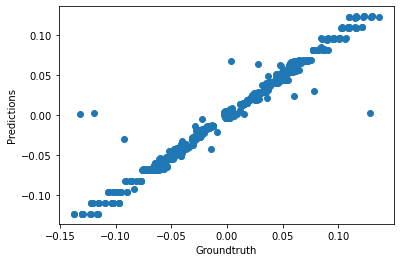

In [75]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")